In [2]:
# Basic system and data packages
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

In [4]:
df = pd.read_csv('../../../data/raw/emissions-populations-dvmt.csv')
#Plot the data set
df

# Drop the first column
df = df.drop(columns=['Unnamed: 0'])

# Set the second column as the row index
df = df.set_index('Year')
df

,Mobile GHG Emissions (MMTCO2e),Agriculture GHG Emissions (MMTCO2e),Commercial GHG Emissions (MMTCO2e),Electricity GHG Emissions (MMTCO2e),Industrial GHG Emissions (MMTCO2e),Residential GHG Emissions (MMTCO2e),Solidwaste GHG Emissions (MMTCO2e),Wastewater GHG Emissions (MMTCO2e),Population,DVMT (Miles)
Year,,,,,,,,,,
1990,15.120625,0.375261,3.828568,11.908703,3.001041,8.279021,1.065912,0.359842,3289056,72072000
1991,15.005884,0.348502,3.662331,12.015808,3.100758,8.024783,1.113482,0.361827,3288640,72948000
1992,15.086747,0.389088,4.312955,11.282676,3.355918,9.505435,1.242805,0.362378,3274997,72293000
1993,15.146864,0.415000,3.843474,10.228667,3.447719,9.081525,1.209374,0.363307,3272325,74025000
1994,15.066461,0.408122,4.172272,10.395885,3.150548,8.677775,1.237386,0.365658,3268346,74352000
1995,14.815692,0.400748,3.841800,10.320433,3.103303,7.977389,1.249919,0.365747,3265293,76830000
1996,15.623592,0.344938,4.133427,10.734700,3.257568,8.461561,1.268976,0.367926,3267030,76874000
1997,15.679850,0.348057,4.301810,13.201970,3.266450,8.186120,1.615209,0.368520,3268514,78202000
1998,15.917011,0.375380,4.036593,12.948870,3.119599,7.122707,1.526577,0.371087,3272563,79936000


In [3]:
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()

mobile_train = df_train['Mobile GHG Emissions (MMTCO2e)']
mobile_test = df_test['Mobile GHG Emissions (MMTCO2e)']

In [4]:
exog1 = df_train['DVMT (Miles)']
exog2 = df_train['Population']
# Combine the exogenous variables
exog_combined = pd.concat([exog1, exog2], axis=1)

exog1_test = df_test['DVMT (Miles)']
exog2_test = df_test['Population']
exog_combined_test = pd.concat([exog1_test, exog2_test], axis=1)

# Fit the model
mod = sm.tsa.arima.ARIMA(mobile_train, order=(1,1,0), exog=exog_combined)#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:     Mobile GHG Emissions (MMTCO2e)   No. Observations:                   26
Model:                             ARIMA(1, 1, 0)   Log Likelihood                 -21.837
Date:                            Wed, 24 Jan 2024   AIC                             51.674
Time:                                    08:23:41   BIC                             56.550
Sample:                                         0   HQIC                            53.026
                                             - 26                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DVMT (Miles)  1.747e-07   1.33e-07      1.312      0.190   -8.63e-08    4.36e-07
Population   -4.913e-06   9.9

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(mobile_train)-1, exog=exog_combined)
train_forecast_mean = train_forecast.predicted_mean
train_forecast_mean_re = train_forecast_mean.iloc[1:]
train_conf_int = train_forecast.conf_int().iloc[1:]

new_index = [2016, 2017, 2018, 2019, 2020, 2021]

# Forecast on test data
test_forecast = res.get_prediction(start=len(mobile_train), end=len(mobile_train)+len(df_test)-1, exog=exog_combined_test)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index


# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Mobile GHG Emissions (MMTCO2e)'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean.iloc[1:]


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the actual values for the test set
actual_values = df_test['Mobile GHG Emissions (MMTCO2e)']

# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['Mobile GHG Emissions (MMTCO2e)']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

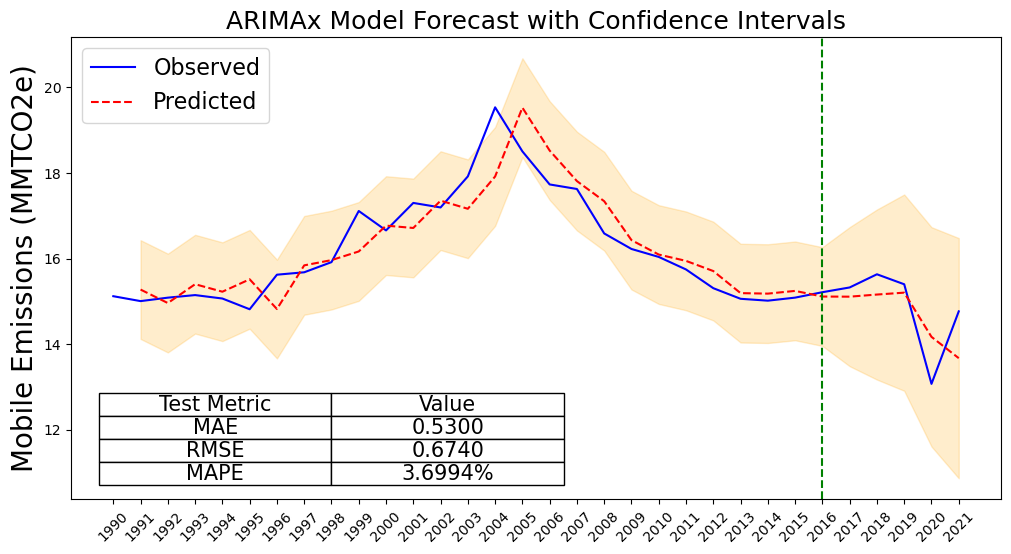

In [7]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the results with confidence bands
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([mobile_train,mobile_test])

#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean_re, test_forecast_df['Mobile GHG Emissions (MMTCO2e)']])

#combine the confidence interval of train and test data
concatenated_interval = pd.concat([train_conf_int, test_conf_int])


#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')


#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')



# Plot confidence bands for training data
plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

#combine the index
combined_index = np.concatenate([mobile_train.index, test_forecast_df.index])

plt.title('ARIMAx Model Forecast with Confidence Intervals', fontsize=18)
# Adjust x-axis ticks and labels
plt.xticks(combined_index, rotation=45)

#plt.xlabel('Time', fontsize=16)
plt.ylabel('Mobile Emissions (MMTCO2e)', fontsize=20)
plt.legend(fontsize=16)

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a vertical line at the x-axis for the year 2016
plt.axvline(x=2016, color='green', linestyle='--', label='Year 2016 (X-axis)')

#create a table to show the MAE and RMSE

# Create a table inside the plot
table_data = [['Test Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', bbox=[0.03, 0.03, 0.5, 0.2], colWidths=[0.2, 0.2, 0.8, 0.8])

# Set font size for the table
table.auto_set_font_size(False)
table.set_fontsize(15)  # Adjust the font size as needed


plt.savefig('../../../figures/Report-images/arimax-mobile-emissions-population-vmt.png', dpi=600, bbox_inches='tight')

In [8]:
import itertools

# Define the range of values for p, d, and q
p_values = range(3)  # Adjust the range based on your preferences
d_values = range(3)
q_values = range(3)

# Initialize a list to store the orders and corresponding AIC and BIC values
order_aic_bic_list = []

# Loop through all combinations of p, d, and q
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit the model for the current combination
        mod = sm.tsa.arima.ARIMA(mobile_train, order=(p, d, q), exog=exog2)
        res = mod.fit()

        # Store the order, AIC, and BIC values in the list
        order_aic_bic_list.append(((p, d, q), res.aic, res.bic))

    except Exception as e:
        # Handle any exceptions that might occur during model fitting
        print(f"Issue with order ({p}, {d}, {q}): {e}")

# Sort the list based on AIC values
order_aic_bic_list.sort(key=lambda x: (x[1], x[2]))

# Print the first five best orders and corresponding AIC and BIC values
for i, (order, aic, bic) in enumerate(order_aic_bic_list[:5]):
    print(f"Rank {i + 1} - Order: {order}, AIC: {aic}, BIC: {bic}")


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

Rank 1 - Order: (1, 1, 0), AIC: 51.3409816121878, BIC: 54.997609086792394
Rank 2 - Order: (0, 1, 1), AIC: 51.77525271011122, BIC: 55.43188018471582
Rank 3 - Order: (2, 2, 0), AIC: 52.075111289785056, BIC: 56.78732661117684
Rank 4 - Order: (2, 1, 0), AIC: 53.32436147502982, BIC: 58.19986477450262
Rank 5 - Order: (0, 1, 2), AIC: 53.81009929781241, BIC: 58.68560259728521


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model

In [19]:
exog_po = pd.read_csv('../../../results/population-forecast-2022to2050.csv')


In [20]:
# Assuming you have an exogenous variable for the future period
exog_variable_future = exog_po 
# Define the extended index
extended_index = list(range(2022, 2051))

# Forecast for the Extended Period with Exogenous Variable
extended_forecast = res.get_forecast(steps=len(extended_index), exog=exog_variable_future)
extended_forecast_mean = extended_forecast.predicted_mean

# Adjust Confidence Interval Index for Extended Forecast
extended_conf_int = extended_forecast.conf_int()
extended_conf_int.index = extended_index

# Create DataFrame for Extended Forecast
extended_forecast_df = pd.DataFrame({'Year': extended_index, 'Population': extended_forecast_mean.values})
extended_forecast_df.set_index('Year', inplace=True)

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
extended_forecast_df

,Population
Year,
2022,15.092822
2023,15.067555
2024,15.090432
2025,15.091205
2026,15.088243
2027,15.096902
2028,15.098784
2029,15.100792
2030,15.105456
